Main Question 1:

* How effective are deep learning models (FNN, GRU, RNN) in predicting employee turnover?

Sub-questions:

* Which deep learning models are the most effective?
* How will these models be evaluated for accuracy?

# Set Up

In [ ]:
!pip install keras-tuner
!pip install --upgrade "scikit-learn==1.2.2" "scikeras==0.11.0"
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 90.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [ ]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler  # For custom color cycles in visualizations

# Progress Tracking
from tqdm import tqdm  # Progress bar for loops and processes

# Scikit-learn (Machine Learning and Preprocessing)
import sklearn
import scikeras
print("Scikit-learn version:", sklearn.__version__)
print("Scikeras version:", scikeras.__version__)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

# Scikeras (Scikit-learn + Keras Integration)
from scikeras.wrappers import KerasClassifier

# TensorFlow and Keras (Deep Learning)
import tensorflow as tf
import random
import optuna
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Keras Tuner
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization

# Configure default plot size for matplotlib
plt.rcParams['figure.figsize'] = (10, 6)

# Define a colorblind-friendly palette
color_palette = [
    "#56B4E9",  # sky blue
    "#009E73",  # green
    "#F0E442",  # yellow
    "#E69F00",  # orange
    "#0072B2",  # blue
    "#D55E00",  # red-orange
    "#CC79A7",  # pink
    "#999999",  # grey
    "#8E44AD",  # purple
    "#FFD700",  # gold
    "#FFB6C1",  # light pink
    "#3CB371",  # medium sea green
    "#FF4500",  # orange-red
    "#4682B4",  # steel blue
    "#B22222",  # firebrick
    "#20B2AA",  # light sea green
    "#8B4513",  # saddle brown
    "#808000",  # olive
    "#FF69B4",  # hot pink
    "#A52A2A",  # brown
]

# Apply the color palette to matplotlib's axes property cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=color_palette)


Scikit-learn version: 1.2.2
Scikeras version: 0.11.0


In [ ]:
# Check the status of the NVIDIA GPU
!nvidia-smi


Tue Jan 14 05:36:27 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Datasets

In [ ]:
# Define the path to your CSV file
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA/final_comment.csv'

# Read the CSV file without using 'date_parser' and without parsing dates initially
comments = pd.read_csv(
    csv_file_path,
    dtype={'comment_like_count': 'int64'},  # Define data type for specific columns
    parse_dates=False                        # Do not parse dates during reading
)

# Convert 'comment_created_date' to datetime with dayfirst=True
comments['comment_created_date'] = pd.to_datetime(
    comments['comment_created_date'],
    dayfirst=True,
    errors='coerce'  # Optional: Handle parsing errors by setting invalid parsing as NaT
)

# Display the DataFrame information to verify successful loading and parsing
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587199 entries, 0 to 587198
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   stream_name             587199 non-null  object        
 1   post_id                 587199 non-null  object        
 2   post_title              587199 non-null  object        
 3   comment_created_date    587199 non-null  datetime64[ns]
 4   comment_id              587199 non-null  object        
 5   userid                  587199 non-null  object        
 6   username                587199 non-null  object        
 7   comment_text            587199 non-null  object        
 8   comment_like_count      587199 non-null  int64         
 9   cleaned_comment_text    587199 non-null  object        
 10  comment_text_sentiment  587199 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 49.3+ MB


In [ ]:
# Read the CSV file
posts= pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/TT/DATA/final_post.csv',
    parse_dates=['post_created_date'], dtype={'post_like_count': 'int64', 'post_comment_count': 'int64'}
)

posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203955 entries, 0 to 203954
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   stream_name           203955 non-null  object        
 1   stream_id             203955 non-null  object        
 2   post_id               203955 non-null  object        
 3   userid                203955 non-null  object        
 4   post_created_date     203955 non-null  datetime64[ns]
 5   post_like_count       203955 non-null  int64         
 6   post_comment_count    203955 non-null  int64         
 7   cleaned_post_text     203955 non-null  object        
 8   post_text_sentiment   203955 non-null  object        
 9   cleaned_post_title    168912 non-null  object        
 10  post_title_sentiment  168912 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 17.1+ MB


In [ ]:
# Read the CSV file
users = pd.read_csv(
    '/content/drive/MyDrive/Colab Notebooks/TT/DATA/user_cleaned.csv',
    parse_dates=[
        'first_login', 'last_login', 'updated', 'used', 'suspended_at', 'created'  # Columns to parse as datetime
    ],
    dtype={
        'suspended': 'bool',                 # Boolean column
        'stream_id': 'object',              # Float column for IDs or numeric values
        'userid': 'object',                  # User ID as string
        'org_unit_id': 'object',             # Organizational unit ID as string
        'position': 'object',                # Position as string
        'country': 'object',                 # Country as string
        'total_of_departments': 'int64',     # Integer column for department counts
        'total_of_jobs': 'int64'             # Integer column for job counts
    }
)

# Display DataFrame information to confirm correct parsing
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151632 entries, 0 to 151631
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   first_login             63468 non-null   datetime64[ns]
 1   suspended               151632 non-null  bool          
 2   stream_id               151632 non-null  object        
 3   userid                  151632 non-null  object        
 4   org_unit_id             151632 non-null  object        
 5   last_login              63468 non-null   datetime64[ns]
 6   updated                 151632 non-null  datetime64[ns]
 7   used                    63464 non-null   datetime64[ns]
 8   display_name_extension  151632 non-null  object        
 9   suspended_at            76809 non-null   datetime64[ns]
 10  created                 151632 non-null  datetime64[ns]
 11  position                151632 non-null  object        
 12  country                 151632

In [ ]:
# Path to the compressed CSV file
input_path = '/content/drive/MyDrive/Colab Notebooks/TT/DATA_CX/activity_cleaned.csv.gz'

# Set the chunk size for reading
chunk_size = 1_000_000  # Number of rows per chunk

# Initialize an empty list to store chunks
chunks = []

# Read the file in chunks with a dynamic progress bar
print("Loading CSV file in chunks...")
with tqdm(total=None, desc="Loading CSV in chunks", unit="chunk") as pbar:
    for chunk in pd.read_csv(input_path, compression='gzip', chunksize=chunk_size):
        # Convert 'occurred_at' column to datetime during chunk processing
        if 'occurred_at' in chunk.columns:
            chunk['occurred_at'] = pd.to_datetime(chunk['occurred_at'])
        chunks.append(chunk)
        pbar.update(1)  # Update the progress bar for each chunk

# Combine chunks into a single DataFrame
activity = pd.concat(chunks, ignore_index=True)

# Display the first few rows to confirm successful loading
print("CSV file successfully loaded into a DataFrame.")
print(activity.info())

Loading CSV file in chunks...


Loading CSV in chunks: 11chunk [00:17,  1.46s/chunk]

# User-Centric Dataset

In [ ]:
# --- Calculation of Metrics from the activity DataFrame ---
print("Processing activity metrics...")

# Create 'is_mobile' column to identify actions from mobile devices
activity['is_mobile'] = activity['client'].apply(lambda x: 1 if x in ['app-android', 'app-ios'] else 0)

# Aggregate activity metrics per user
activity_summary = activity.groupby('userid').agg(
    total_actions=('method', 'count'),
    total_get=('method', lambda x: (x == 'GET').sum()),
    total_post=('method', lambda x: (x == 'POST').sum()),
    unique_paths=('normalized_path', 'nunique'),
    avg_turnaround_time=('turnaround_time', 'mean'),
    max_turnaround_time=('turnaround_time', 'max'),
    active_days=('occurred_at', lambda x: x.dt.date.nunique()),
    mobile_actions=('is_mobile', 'sum')
).reset_index()

# Calculate additional metrics
activity_summary['post_get_ratio'] = activity_summary['total_post'] / (activity_summary['total_get'] + 1)
activity_summary['avg_actions_per_day'] = activity_summary['total_actions'] / activity_summary['active_days']

# Calculate total activity duration
activity_summary['activity_duration_days'] = (
    activity.groupby('userid')['occurred_at'].max() - activity.groupby('userid')['occurred_at'].min()
).dt.days

# --- Posts Metrics ---
print("Processing posts metrics...")
posts_summary = posts.groupby('userid').agg(
    total_posts=('post_id', 'count'),
    avg_post_likes=('post_like_count', 'mean'),
    avg_post_comments=('post_comment_count', 'mean')
).reset_index()

# --- Comments Metrics ---
print("Processing comments metrics...")
comments_summary = comments.groupby('userid').agg(
    total_comments=('comment_id', 'count'),
    avg_comment_likes=('comment_like_count', 'mean')
).reset_index()

# --- Users Metrics ---
print("Processing user metadata...")
users_summary = users[['userid', 'suspended', 'days_active', 'total_of_jobs', 'total_of_departments']]

# --- Combine All Metrics ---
print("Merging datasets into the user-centric dataset...")
user_dataset = (
    users_summary
    .merge(activity_summary, on='userid', how='left')
    .merge(posts_summary, on='userid', how='left')
    .merge(comments_summary, on='userid', how='left')
)

# --- Preprocessing ---
print("Finalizing user-centric dataset...")

# Fill missing values
user_dataset.fillna(0, inplace=True)

print("\nSample of the User-Centric Dataset:")
print(user_dataset.head())



Processing activity metrics...
Processing posts metrics...
Processing comments metrics...
Processing user metadata...
Merging datasets into the user-centric dataset...
Finalizing user-centric dataset...

Sample of the User-Centric Dataset:
                                 userid  suspended  days_active  \
0  3ec55b31-9e19-4e89-bb57-ad612cd01e0a      False            1   
1  c75ab72a-825a-4731-be70-1c56cf032e99      False          158   
2  5318adf7-7b26-479c-bdc9-f2d04251b991      False            9   
3  83c5c9bd-f2fb-4ef2-8dff-c7ba400e1942      False          156   
4  6b5f7c10-c563-4c9c-9acc-184d460e9753      False           89   

   total_of_jobs  total_of_departments  total_actions  total_get  total_post  \
0              3                     3           12.0       10.0         2.0   
1              1                     1         5013.0     4995.0        18.0   
2              1                     1            9.0        9.0         0.0   
3              1                     

# Hyperparameter optimization

# 1. Manual Grid Search

Training with lr=0.001, dropout_rate=0.2, neurons_1=64, neurons_2=32, batch_size=32, epochs=20
Training with lr=0.001, dropout_rate=0.2, neurons_1=64, neurons_2=32, batch_size=32, epochs=50
Training with lr=0.001, dropout_rate=0.2, neurons_1=64, neurons_2=32, batch_size=64, epochs=20
Training with lr=0.001, dropout_rate=0.2, neurons_1=64, neurons_2=32, batch_size=64, epochs=50
Training with lr=0.001, dropout_rate=0.2, neurons_1=64, neurons_2=64, batch_size=32, epochs=20
Training with lr=0.001, dropout_rate=0.2, neurons_1=64, neurons_2=64, batch_size=32, epochs=50
Training with lr=0.001, dropout_rate=0.2, neurons_1=64, neurons_2=64, batch_size=64, epochs=20
Training with lr=0.001, dropout_rate=0.2, neurons_1=64, neurons_2=64, batch_size=64, epochs=50
Training with lr=0.001, dropout_rate=0.2, neurons_1=128, neurons_2=32, batch_size=32, epochs=20
Training with lr=0.001, dropout_rate=0.2, neurons_1=128, neurons_2=32, batch_size=32, epochs=50
Training with lr=0.001, dropout_rate=0.2, neuron

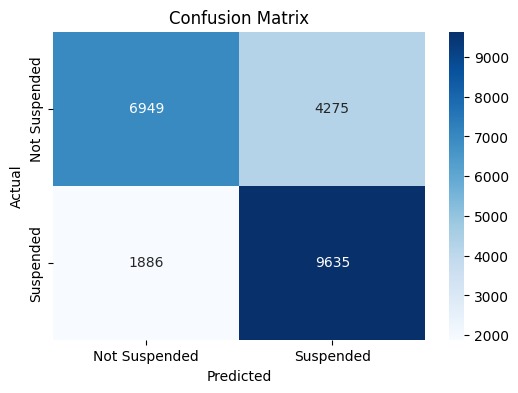

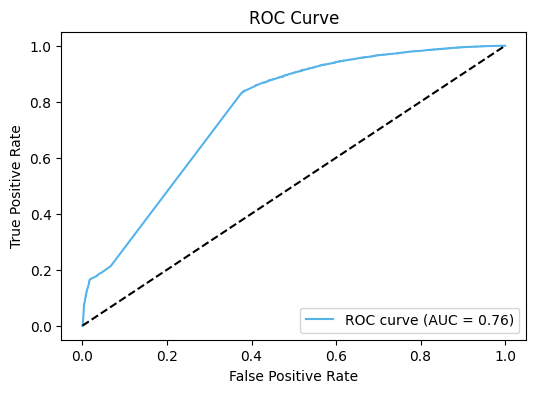

ROC AUC: 0.76


In [ ]:
# --- Step 1. Set Random Seeds for Reproducibility ---
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# --- Step 2. Load and Prepare the Dataset ---
# Drop unnecessary columns and split features (X) from the target (y)
columns_to_drop = ['userid', 'suspended']
X = user_dataset.drop(columns=columns_to_drop)  # Features
y = user_dataset['suspended']  # Target

# Encode target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# --- Step 3. Split the Data ---
# Split into Train (70%) and Temporary (30%) datasets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=SEED,
    stratify=y
)

# Further split Temporary set into Validation (15%) and Test (15%) datasets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_temp
)

# --- Step 4. Standardize the Features ---
# Standardize the features to have zero mean and unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on training data
X_val_scaled = scaler.transform(X_val)         # Use the same scaler
X_test_scaled = scaler.transform(X_test)

# --- Step 5. Define the Model Creation Function ---
def create_model(input_dim, lr=0.001, dropout_rate=0.3, neurons_1=64, neurons_2=32):
    """
    Build and compile a simple feed-forward neural network.

    Args:
        input_dim (int): Number of input features.
        lr (float): Learning rate for the optimizer.
        dropout_rate (float): Dropout rate for regularization.
        neurons_1 (int): Number of neurons in the first hidden layer.
        neurons_2 (int): Number of neurons in the second hidden layer.

    Returns:
        model (Sequential): Compiled Keras model.
    """
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons_1, activation='relu'),
        Dropout(dropout_rate),
        Dense(neurons_2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- Step 6. Manual Hyperparameter Search ---
# Define the grid of hyperparameters to search
param_grid = {
    "lr": [0.001, 0.0005, 0.0001],
    "dropout_rate": [0.2, 0.3, 0.4],
    "neurons_1": [64, 128, 256],
    "neurons_2": [32, 64],
    "batch_size": [32, 64],
    "epochs": [20, 50]
}

# Variables to store the best configuration
best_model = None
best_val_loss = float("inf")
best_params = None
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Iterate through all combinations of hyperparameters
for lr in param_grid["lr"]:
    for dropout_rate in param_grid["dropout_rate"]:
        for neurons_1 in param_grid["neurons_1"]:
            for neurons_2 in param_grid["neurons_2"]:
                for batch_size in param_grid["batch_size"]:
                    for epochs in param_grid["epochs"]:
                        print(f"Training with lr={lr}, dropout_rate={dropout_rate}, neurons_1={neurons_1}, "
                              f"neurons_2={neurons_2}, batch_size={batch_size}, epochs={epochs}")

                        # Create and train the model
                        model = create_model(
                            input_dim=X_train_scaled.shape[1],
                            lr=lr,
                            dropout_rate=dropout_rate,
                            neurons_1=neurons_1,
                            neurons_2=neurons_2
                        )
                        history = model.fit(
                            X_train_scaled, y_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val_scaled, y_val),
                            callbacks=[early_stopping],  # Add EarlyStopping callback
                            verbose=0  # Suppress output for clarity
                        )

                        # Track the validation loss
                        val_loss = min(history.history["val_loss"])
                        if val_loss < best_val_loss:
                            best_val_loss = val_loss
                            best_model = model
                            best_params = {
                                "lr": lr,
                                "dropout_rate": dropout_rate,
                                "neurons_1": neurons_1,
                                "neurons_2": neurons_2,
                                "batch_size": batch_size,
                                "epochs": epochs
                            }

print("\nBest Hyperparameters:", best_params)
print("Best Validation Loss:", best_val_loss)

# --- Step 7. Train the Final Model with Best Parameters ---
print("\nTraining the Final Model with the Best Parameters...")
final_model = create_model(
    input_dim=X_train_scaled.shape[1],
    lr=best_params["lr"],
    dropout_rate=best_params["dropout_rate"],
    neurons_1=best_params["neurons_1"],
    neurons_2=best_params["neurons_2"]
)

history = final_model.fit(
    X_train_scaled, y_train,
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping],  # Add EarlyStopping callback
    verbose=1
)

# --- Step 8. Evaluate the Model on the Test Set ---
loss, accuracy = final_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nTest Accuracy: {accuracy:.2f}")

# --- Step 9. Generate Predictions and Evaluate Metrics ---
y_pred_prob = final_model.predict(X_test_scaled).ravel()  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype(int)                  # Predicted classes

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Suspended', 'Suspended'],
            yticklabels=['Not Suspended', 'Suspended'])
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- Step 10. ROC Curve and AUC ---
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC: {roc_auc:.2f}")


**Test Accuracy:** 73%

Interpretation: The model correctly predicts employee suspension status 73% of the time on unseen data.

**ROC AUC:** 0.76

Interpretation: The Receiver Operating Characteristic Area Under the Curve (ROC AUC) score of 0.76 suggests that the model has good discriminative ability to distinguish between employees who will be suspended and those who will not. An ROC AUC closer to 1.0 signifies excellent discrimination, while 0.5 indicates no discriminative power.


**Classification Report:**

Precision: Indicates that when the model predicts an employee will be suspended (True), it is correct 69% of the time. For non-suspensions (False), the precision is higher at 79%.

Recall: The model successfully identifies 84% of actual suspensions (True) but only 62% of non-suspensions (False). This imbalance suggests the model is better at detecting suspensions than non-suspensions.

F1-Score: 0.73, reflecting the balance between precision and recall across both classes.

The model is more effective at identifying employees who are likely to be suspended (high recall for class 1) than those who will remain active (lower recall for class 0)


# 2. Bayesian Hyperparameter Optimization Using Optuna

[I 2025-01-09 05:21:49,285] A new study created in memory with name: no-name-7744e9aa-7a48-48a2-baee-43a3f5662146
[I 2025-01-09 05:22:47,392] Trial 0 finished with value: 0.7293471097946167 and parameters: {'lr': 0.008385956111108194, 'dropout_rate': 0.3497320923040163, 'neurons_1': 64, 'neurons_2': 64, 'batch_size': 64, 'epochs': 46}. Best is trial 0 with value: 0.7293471097946167.
[I 2025-01-09 05:26:51,360] Trial 1 finished with value: 0.7308419346809387 and parameters: {'lr': 0.00017698209134181774, 'dropout_rate': 0.4321500412900663, 'neurons_1': 128, 'neurons_2': 32, 'batch_size': 32, 'epochs': 45}. Best is trial 1 with value: 0.7308419346809387.
[I 2025-01-09 05:28:59,796] Trial 2 finished with value: 0.7291272878646851 and parameters: {'lr': 0.0002651301169561325, 'dropout_rate': 0.3729682533509254, 'neurons_1': 64, 'neurons_2': 64, 'batch_size': 32, 'epochs': 23}. Best is trial 1 with value: 0.7308419346809387.
[I 2025-01-09 05:32:26,577] Trial 3 finished with value: 0.7343592

Best hyperparameters:  {'lr': 0.0012513917030583922, 'dropout_rate': 0.2310801028185709, 'neurons_1': 256, 'neurons_2': 64, 'batch_size': 64, 'epochs': 36}
Best validation accuracy:  0.7374367713928223
Epoch 1/36
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - binary_accuracy: 0.7275 - loss: 0.5632
Epoch 2/36
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - binary_accuracy: 0.7323 - loss: 0.5518
Epoch 3/36
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - binary_accuracy: 0.7338 - loss: 0.5473
Epoch 4/36
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - binary_accuracy: 0.7346 - loss: 0.5443
Epoch 5/36
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - binary_accuracy: 0.7352 - loss: 0.5420
Epoch 6/36
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - binary_accuracy: 0.7358 - loss: 0.5399
Epoch 7/36
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - binary_accuracy: 0.7363 - loss: 0.5381
Epoch 8/36
2014/2014 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - binary_accuracy: 0.7372 - loss: 0.5368
Epoch 9/36
2014/2014 ━━━━━━━━━━━━━━━━━

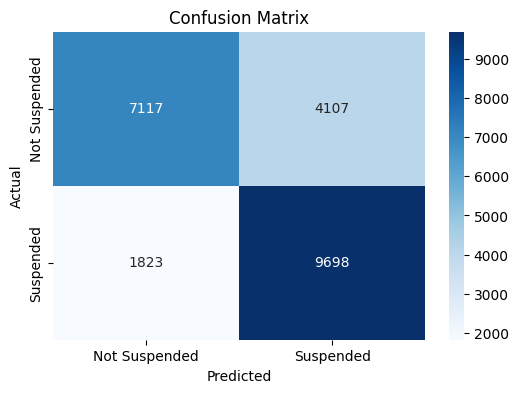

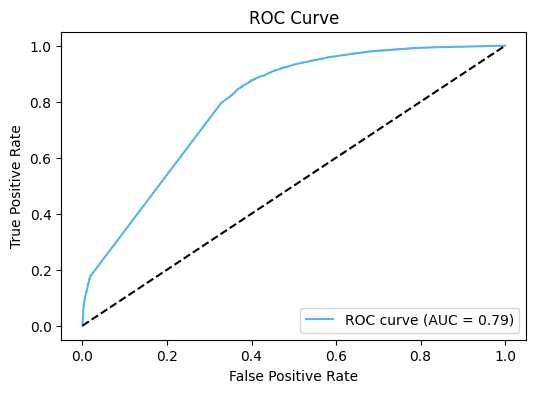

ROC AUC: 0.79


In [ ]:
# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# =============================================================================
# Step 1: Load and Prepare Your Dataset
# =============================================================================

# Ensure user_dataset is loaded before this script
columns_to_drop = ['userid', 'suspended']
X = user_dataset.drop(columns=columns_to_drop)
y = user_dataset['suspended']

# =============================================================================
# Encode Target Labels
# =============================================================================
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Converts non-numeric labels to integers (0, 1)

# =============================================================================
# Step 2: Split Data into Train / Validation / Test
# =============================================================================

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
)

# =============================================================================
# Step 3: Standardize the Features
# =============================================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# =============================================================================
# Step 4: Define the Keras Model Creation Function
# =============================================================================

def create_model(input_dim, lr, dropout_rate, neurons_1, neurons_2):
    model = Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),  # Using an Input layer
        Dense(neurons_1, activation='relu'),
        Dropout(dropout_rate),
        Dense(neurons_2, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.BinaryAccuracy()]
    )
    return model

# =============================================================================
# Step 5: Define the Optuna Objective Function
# =============================================================================

def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    neurons_1 = trial.suggest_categorical('neurons_1', [64, 128, 256])
    neurons_2 = trial.suggest_categorical('neurons_2', [32, 64])
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    epochs = trial.suggest_int('epochs', 20, 50)

    model = create_model(
        input_dim=X_train_scaled.shape[1],
        lr=lr,
        dropout_rate=dropout_rate,
        neurons_1=neurons_1,
        neurons_2=neurons_2
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=0
    )

    val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
    return val_accuracy

# =============================================================================
# Step 6: Run the Optuna Study
# =============================================================================

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best hyperparameters: ", study.best_params)
print("Best validation accuracy: ", study.best_value)

# =============================================================================
# Step 7: Train the Final Model with Best Hyperparameters
# =============================================================================

best_params = study.best_params

X_final_train = np.concatenate([X_train_scaled, X_val_scaled])
y_final_train = np.concatenate([y_train, y_val])

final_model = create_model(
    input_dim=X_train_scaled.shape[1],
    lr=best_params['lr'],
    dropout_rate=best_params['dropout_rate'],
    neurons_1=best_params['neurons_1'],
    neurons_2=best_params['neurons_2']
)

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

final_model.fit(
    X_final_train, y_final_train,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    callbacks=[early_stopping],
    verbose=1
)

# =============================================================================
# Step 8: Evaluate the Final Model on the Test Set
# =============================================================================

test_loss, test_accuracy = final_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

# =============================================================================
# Step 9: Further Evaluation and Analysis
# =============================================================================

y_pred_prob = final_model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Suspended', 'Suspended'],
            yticklabels=['Not Suspended', 'Suspended'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
print(f"ROC AUC: {roc_auc:.2f}")

**Test Accuracy:** 74%

Interpretation: The model correctly predicts employee suspension status 73.93% of the time on unseen data.

**ROC AUC:** 0.79
Interpretation:Indicates good discrimination between the True and False classes.

**Classification Report:**

Precision: Indicates that when the model predicts an employee will be suspended (True), it is correct 80% of the time. For non-suspensions (False), the precision is higher at 70%.

Recall: The model successfully identifies 84% of actual suspensions (True) but only 63% of non-suspensions (False). This imbalance suggests the model is better at detecting suspensions than non-suspensions.

F1-Score: 0.74, reflecting the contribution of each class based on its size. Balances precision and recall, with higher scores indicating better performance. The F1-scores reflect the same trend as precision and recall.

# 3. Hyperparameter Tuning with Keras Tuner

Trial 20 Complete [00h 04m 17s]
val_accuracy: 0.7344031929969788

Best val_accuracy So Far: 0.7388876676559448
Total elapsed time: 01h 23m 36s
Best Hyperparameters (Keras Tuner):
{'neurons_1': 128, 'dropout_rate': 0.2, 'neurons_2': 64, 'lr': 0.0005}
Epoch 1/20
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7250 - loss: 0.5676 - val_accuracy: 0.7281 - val_loss: 0.5515
Epoch 2/20
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7313 - loss: 0.5530 - val_accuracy: 0.7288 - val_loss: 0.5487
Epoch 3/20
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7318 - loss: 0.5498 - val_accuracy: 0.7295 - val_loss: 0.5468
Epoch 4/20
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7323 - loss: 0.5476 - val_accuracy: 0.7297 - val_loss: 0.5449
Epoch 5/20
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7328 - loss: 0.5453 - val_accuracy: 0.7301 - val_loss: 0.5434
Epoch 6/20
3317/3317 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7331 - loss: 0.5444 - val_accura

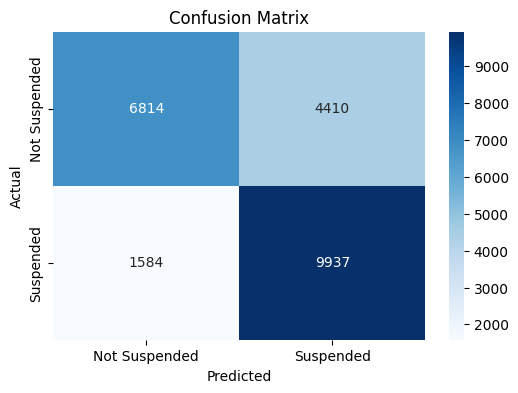

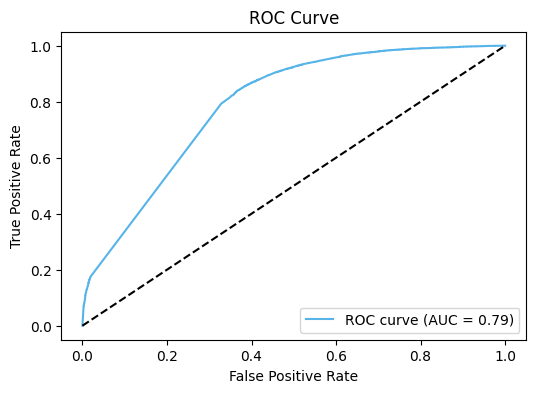

In [ ]:
# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# =============================================================================
# 2. Load Data and Prepare Features/Target
# =============================================================================
columns_to_drop = ['userid', 'suspended']  # Columns not needed
X = user_dataset.drop(columns=columns_to_drop)  # Features
y = user_dataset['suspended']  # Target

# Encode target as integers (convert from bool to int)
y = y.astype(int)

# =============================================================================
# 3. Split into Train (70%) and Temp (30%)
# =============================================================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=SEED,
    stratify=y
)

# =============================================================================
# 4. Split Temp (30%) into Validation (15%) and Test (15%)
# =============================================================================
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=SEED,
    stratify=y_temp
)

# =============================================================================
# 5. Standardize Features
# =============================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on Train
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# =============================================================================
# 6. Analyze Class Distribution and Compute Class Weights
# =============================================================================
print("Class distribution in y_train:")
print(pd.Series(y_train).value_counts())

# Compute class weights
unique_classes = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)

# Convert to dictionary
class_weights = dict(zip(unique_classes, class_weights_array))
print("Class Weights:", class_weights)

# Ensure y_train and y_val are Numpy arrays
y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
y_val = y_val.to_numpy() if isinstance(y_val, pd.Series) else y_val
y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

# =============================================================================
# 7. Define the Function to Create the Model (Keras Tuner)
# =============================================================================
def build_model(hp):

    model = Sequential()

    # Input layer
    model.add(Input(shape=(X_train_scaled.shape[1],)))

    # Hidden layers
    neurons_1 = hp.Choice('neurons_1', values=[64, 128, 256])
    model.add(Dense(neurons_1, activation='relu'))
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])))

    neurons_2 = hp.Choice('neurons_2', values=[32, 64])
    model.add(Dense(neurons_2, activation='relu'))
    model.add(Dropout(hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4])))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', values=[0.001, 0.0005, 0.0001])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# =============================================================================
# 8. Configure and Start Hyperparameter Search (Keras Tuner)
# =============================================================================
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory='my_dir',
    project_name='keras_tuner_demo'
)

tuner.search(
    X_train_scaled, y_train,
    epochs=50,
    validation_data=(X_val_scaled, y_val),
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters (Keras Tuner):")
print(best_hps.values)

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# =============================================================================
# 9. Train the Best Model from Scratch with Class Weights
# =============================================================================
history = best_model.fit(
    X_train_scaled, y_train,
    epochs=20,
    validation_data=(X_val_scaled, y_val),
    class_weight=class_weights,
    verbose=1
)

# =============================================================================
# 10. Evaluate on Test Set and Generate Metrics
# =============================================================================
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_prob = best_model.predict(X_test_scaled).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Suspended', 'Suspended'], yticklabels=['Not Suspended', 'Suspended'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


**Test Accuracy:** 74%

Interpretation: The model correctly predicts employee suspension status 74% of the time on unseen data.

**ROC AUC:** 0.79
Interpretation:Indicates good discrimination between the True and False classes.

**Classification Report:**

Precision: Indicates that when the model predicts an employee will be suspended (True), it is correct 69% of the time. For non-suspensions (False), the precision is higher at 81%.

Recall: The model successfully identifies 86% of actual suspensions (True) but only 61% of non-suspensions (False). This imbalance suggests the model is better at detecting suspensions than non-suspensions.

F1-Score: 0.73, reflecting the contribution of each class based on its size. Balances precision and recall, with higher scores indicating better performance. The F1-scores reflect the same trend as precision and recall.